In [1]:
%matplotlib inline

import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from IPython.display import display

In [2]:
FS_OD_PLOT = 5, 3.5
FS_MU_SIGMA_PLOT = 4, 3.5
FS_SPECTRAL_REGION_PLOT = 8, 4.5

DPI = 240
IMG_DIR = '../img'
def save_fig(fig, name):
    fig.savefig(os.path.join(IMG_DIR, name), dpi=DPI)

In [3]:
# axis 0: OD0 (offen), OD1 (nicht existent), OD2, OD3, OD4
# axis 1: Mittelung über 1, 10, 100 Werte
# axis 2: (µ, σ)

voltages_OD = np.array([[[ 2.495, 1.0e-3], [2.502,   300e-6], [ 2.5153, 80e-6]],
                        [[np.nan, np.nan], [np.nan,  np.nan], [np.nan, np.nan]],
                        [[28.2e-3, .2e-3], [28.15e-3, 25e-6], [28.15e-3, 5e-6]],
                        [[np.nan, np.nan], [ 6.35e-3, 27e-6], [np.nan, np.nan]],
                        [[np.nan, np.nan], [ 4.25e-3, 25e-6], [np.nan, np.nan]]])
axis_OD = np.arange(5)
axis_avg = np.array([1, 10, 100])

In [4]:
def plot_OD(voltages, ax, ylim=[1e-4, 10]):
    ax.set_yscale('log', nonposy='clip')
    ax.grid()
    ax.set_ylim(ylim)
    ax.set_xticks(axis_OD)
    
    mask = ~np.any(np.isnan(voltages), axis=1)
    mu = voltages[:,0][mask]
    sigma = voltages[:,1][mask]
    index = axis_OD[mask]
    
    ax.errorbar(index, mu, yerr=2*sigma, fmt='o', label=r"Messung ($\mu$, $\sigma$)")
    
    v_calc = voltages[0,0] * np.power(10., -axis_OD)
    ax.plot(axis_OD, v_calc, ls='--', lw=1, color='k', label="berechnet")
    
    ax.legend()

In [5]:
def plot_sigma(voltages, ax, label, normalize=False):
    ax.set_xscale('log')
    ax.grid()
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    voltages_normalized = voltages - np.array([voltages[-1,0], 0])
    my_voltages = voltages_normalized if normalize else voltages
    mu = my_voltages[:,0]
    sigma = my_voltages[:,1]

    ax.errorbar(axis_avg, mu, yerr=2*sigma, fmt='o', label=label)
    ax.legend()

## a) Messung der optischen Dichte mit Gleichlicht

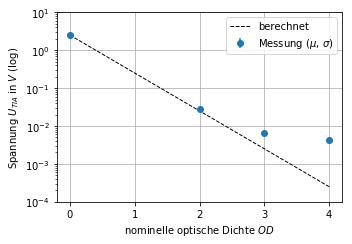

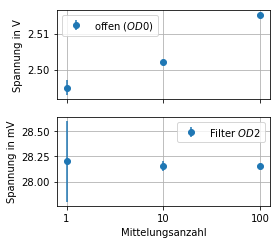

In [6]:
fig, ax = plt.subplots(1, 1, figsize=FS_OD_PLOT)
plot_OD(voltages_OD[:,1], ax)

# fig.suptitle("Spannungssignal Fotodetektor über optischer Dichte")
ax.set_xlabel("nominelle optische Dichte $OD$")
ax.set_ylabel(r"Spannung $U_{TIA}$ in $V$ (log)")

fig.tight_layout()
save_fig(fig, '1a-gleichlicht-OD')

# --------------------------------

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=FS_MU_SIGMA_PLOT, sharex=True)

plot_sigma(voltages_OD[0], ax0, label="offen ($OD0$)")
plot_sigma(voltages_OD[2]/1e-3, ax1, label="Filter $OD2$")

# fig.suptitle(r"Mittelwert und $2\sigma$-Umgebung")
ax0.set_ylabel("Spannung in V")
ax1.set_ylabel("Spannung in mV")
ax1.set_xlabel("Mittelungsanzahl")

fig.tight_layout()
save_fig(fig, '1a-gleichlicht-mu-sigma')

## b) Kompensation des Einflusses des Umgebungslichts

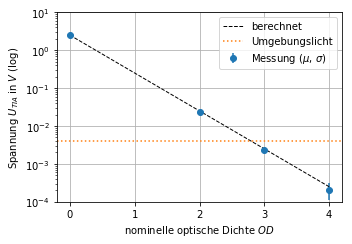

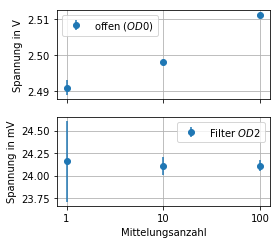

In [7]:
sys_err_mu, sys_err_sigma = 4.04e-3, 25e-6
voltages_OD_compensated = voltages_OD + np.array([-sys_err_mu, sys_err_sigma])

fig, ax = plt.subplots(1, 1, figsize=FS_OD_PLOT)
plot_OD(voltages_OD_compensated[:,1], ax)

# fig.suptitle("Spannungssignal Fotodetektor über optischer Dichte")
ax.set_xlabel("nominelle optische Dichte $OD$")
ax.set_ylabel(r"Spannung $U_{TIA}$ in $V$ (log)")
ax.axhline(sys_err_mu, ls=':', c='C1', label="Umgebungslicht")
ax.legend()

fig.tight_layout()
save_fig(fig, '1b-gleichlicht-kompensiert-OD')

# --------------------------------

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=FS_MU_SIGMA_PLOT, sharex=True)

plot_sigma(voltages_OD_compensated[0], ax0, label="offen ($OD0$)")
plot_sigma(voltages_OD_compensated[2]/1e-3, ax1, label="Filter $OD2$")

# fig.suptitle(r"Mittelwert und $2\sigma$-Umgebung")
ax0.set_ylabel("Spannung in V")
ax1.set_ylabel("Spannung in mV")
ax1.set_xlabel("Mittelungsanzahl")

fig.tight_layout()
save_fig(fig, '1b-gleichlicht-kompensiert-mu-sigma')

## c) Suchen eines ruhigen Spektralbereichs

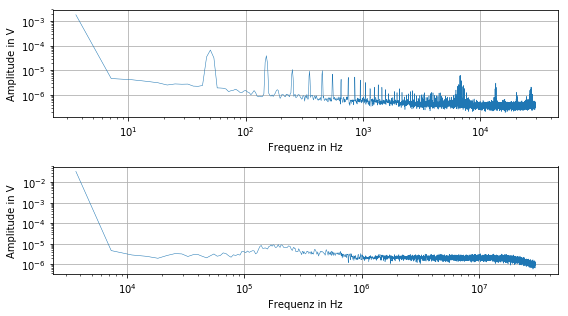

In [8]:
fnames = '../data/1-OD/1c-30kHz.txt', '../data/1-OD/1c-30MHz.txt'

fig, axes = plt.subplots(2, figsize=FS_SPECTRAL_REGION_PLOT)

for fname, ax in zip(fnames, axes):
    data = pd.read_csv(fname, comment='%', delimiter=';', names=['freq', 'mag'])
    ax.loglog(data.freq, data.mag, lw=.5, label=fname)
    ax.grid()
    # ax.set_ylim(1e-7, 1e-2)
    ax.set_xlabel("Frequenz in Hz")
    ax.set_ylabel("Amplitude in V")

fig.tight_layout()
save_fig(fig, '1c-spektralbereich')

## d) Messung der optischen Dichte per Lock-In-Verfahren

In [9]:
# axis 0: OD0 (offen), OD1 (nicht existent), OD2, OD3, OD4
# axis 1: (µ, σ)

voltages_OD_HF = np.array([[50.6e-3,  17e-6],
                           [np.nan,  np.nan],
                           [503e-6,  600e-9],
                           [48.6e-6, 400e-9],
                           [ 4.9e-6, 400e-9]])

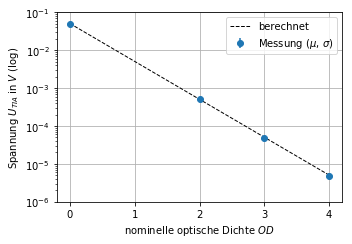

In [10]:
fig, ax = plt.subplots(1, 1, figsize=FS_OD_PLOT)
plot_OD(voltages_OD_HF, ax, ylim=[1e-6,1e-1])

# fig.suptitle("Spannungssignal Fotodetektor über optischer Dichte")
ax.set_xlabel("nominelle optische Dichte $OD$")
ax.set_ylabel(r"Spannung $U_{TIA}$ in $V$ (log)")

fig.tight_layout()
save_fig(fig, '1d-lock-in-OD')

## e) Vergleich der Messergebnisse

Gleichlicht  Gleichlicht kompensiert  Lock-In-Verfahren
2     1.948809                 2.015388           2.002583
3     2.595514                 3.033973           3.017514
4     2.769898                 4.075366           4.013954

Gleichlicht  Gleichlicht kompensiert  Lock-In-Verfahren
2     0.051191                 0.015388           0.002583
3     0.404486                 0.033973           0.017514
4     1.230102                 0.075366           0.013954

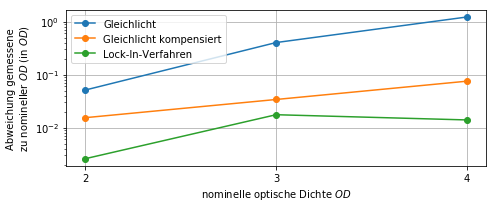

In [11]:
def OD(voltages):
    v0 = voltages[0,0]
    return np.log10(v0/voltages[:,0])

od_val = pd.DataFrame({'Gleichlicht': OD(voltages_OD[:,1]),
                       'Gleichlicht kompensiert': OD(voltages_OD_compensated[:,1]),
                       'Lock-In-Verfahren': OD(voltages_OD_HF)})[2:]
od_err = od_val.sub(od_val.index, axis='index').abs()

display(od_val)
display(od_err)

fig, ax = plt.subplots(figsize=(7, 3))
od_err.plot(logy=True, grid=True, xticks=[2, 3, 4], ax=ax, marker='o')
ax.set_xlabel("nominelle optische Dichte $OD$")
ax.set_ylabel("Abweichung gemessene\nzu nomineller $OD$ (in $OD$)")

fig.tight_layout()
save_fig(fig, '1e-abweichung')